# LGIEKF Attitude Filter (Lie Group Invariant EKF)

This filter uses a geometrically accurate measurement correction, that is appropriate for measurements on a manifold. In this case, we measure the attitude of the vehicle relative to the magnetic field and also we measure the direction of the gravity. When the acceleration is near g, it can be assumed that the vehicle is on the ground or in a stable hover and, the direction of gravity can be use to correct the attitude.

Although the measurements are actually vectors, they are transformed into elements of SO3. One represenation of SO3 is a direction cosine matrix. From the Lie Group Extended Kalman Filter, we use a slightly modified correction term so that it is right invariant:

$$\hat{X}_{k|k} = \hat{X}_{k|k-1}\exp_{G} \left(
    K \log_{G'}\left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
\right) $$

Here $T_y$ represents the mapping of the true measurement to the manifold. Although a bijection does not exist between SO3 and the vector measurements, a map can be constructed that is closest to the original state, so that the measurements only modifies the states that it is observing. For instance, if $y$ is measuring the magnetic heading, we wish to only induce a rotation about the down direction in the navigation frame, so we choose $T_y$ so that $\eta = h(\hat{X}_{k|k-1}) T_y(y_k)^{-1} = R_3(\xi_3)$, where $R_3$ represents a rotation around the world 3 axis.

$$ H = \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee} \left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
$$

### TODO

* Correctly handle noise on manifolds.
* Generate C code.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.integrate
from IPython.display import Image
from casadi.tools.graph import graph
import casadi as ca

# this library
from pyecca.so3.mrp import Mrp
from pyecca.so3.quat import Quat
from pyecca.so3.dcm import Dcm


def draw_graph(x):
    g = graph.dotgraph(x)
    #g.set('dpi', 300)
    png = g.create('dot', 'png')
    return Image(png)

## Filter Derivation

This needs to be cleaned up.

In [2]:
class SO3xR3(ca.SX):
    """
    Direct product of SO3 and R3
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert self.shape == (6, 1)
        self.r = Mrp(self[0:3])
        self.b = self[3:6]

    def inv(self):
        return self.__class__(ca.vertcat(self.r.inv(), -self.b))
    
    def __mul__(self, other):
        r = self.r*other.r
        b  = self.b + other.b
        return self.__class__(ca.vertcat(r, b))

    @classmethod
    def exp(cls, xi):
        return cls(ca.vertcat(Mrp.exp(xi[0:3]), xi[3:6]))

    def log(self):
        return ca.vertcat(self.r.log(), self.b)

    def shadow_if_needed(self):
        r = ca.if_else(ca.norm_2(self.r) >1, self.r.shadow(), self.r)
        return self.__class__(ca.vertcat(r, self.b))

### Prediction



In [3]:
n_x = 6

x = SO3xR3(ca.SX.sym('x', 6, 1))
x_h = SO3xR3(ca.SX.sym('x_h', 6, 1))
q = Quat(ca.SX.sym('q', 4, 1))
omega_b = ca.SX.sym('omega_b', 3, 1)

#w = ca.SX.sym('w', 3, 1)
f_dynamics = ca.Function(
    "dyn", [x, omega_b],
    [ca.vertcat(x.r.derivative(omega_b - x.b), ca.SX([0, 0, 0])).T],
    ['x', 'omega_b'], ['x_dot'])

eta = SO3xR3(ca.SX.sym('eta', 6, 1)) # (right)
f = ca.Function('f', [eta, x_h], [ca.vertcat(-ca.mtimes(x_h.r.to_dcm(), eta.b), ca.SX.zeros(3))])
f_J = ca.jacobian(f(eta, x_h), eta)

# note, the estimated error is always zero when propagating the
# covariance, we might want the F without zero eta_R, when doing
# the LGEKF covariance correction term
F = ca.sparsify(ca.substitute(f_J, eta, ca.SX.zeros(n_x)))
f_F = ca.Function('F', [x_h], [F])
Q = ca.SX.sym('Q', ca.Sparsity.diag(6))

# find sparsity pattern of P
P0 = ca.SX.sym('P0', ca.Sparsity.diag(6))
P_sparse = P0
# loop for number of states to ensure covariance has fully propagated
for i in range(n_x):
    P_sparse = ca.mtimes(F, P_sparse) + ca.mtimes(P_sparse, F.T) + Q
PU = ca.SX.sym('P', ca.triu(P_sparse).sparsity())

# covariance prediction
P = ca.triu2symm(PU)
dP = ca.mtimes(F, P) + ca.mtimes(P, F.T) + Q
dP = ca.substitute(dP, eta, ca.SX.zeros(6))
dP = ca.sparsify(ca.triu2symm(ca.triu(dP))) # force symmetric, simplifies graph
f_dP = ca.Function('dP', [x_h, PU, Q], [dP])

In [4]:
PU.sparsity().spy()

******
.*****
..****
...*..
....*.
.....*


### Magnetometer Correction

For the case of the magnetic heading, we calculate:

\begin{align} H_{mag} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_3(\xi_3)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \xi_3 \\
&= \begin{pmatrix} 0 & 0 & 1\end{pmatrix}
\end{align}

In [5]:
H_mag = ca.SX(1, 6)
H_mag[0, 2] = 1

f_measure_hdg = ca.Function('measure_hdg', [x], [ca.mtimes(x.r.to_dcm().T, ca.SX([1, 0, 0]))])
yh_mag = f_measure_hdg(x_h)

R_mag = ca.SX.sym('R_mag', ca.Sparsity.diag(1))
S_mag = ca.mtimes([H_mag, P, H_mag.T]) + R_mag
K_mag = ca.mtimes([P, H_mag.T, ca.inv(S_mag)])
P_mag = P - ca.mtimes([K_mag, H_mag, P])
P_mag = ca.triu2symm(ca.triu(P_mag)) # force symmetric, simplifies graph

y_b = ca.SX.sym('y_b', 3, 1)
B_n = ca.SX.sym('B_n', 3, 1)
R_nb = x_h.r.to_dcm()
y_n = ca.mtimes(R_nb, y_b)
v_n = ca.cross(y_n, B_n)/ca.norm_2(y_n)/ca.norm_2(B_n)
norm_v = ca.norm_2(v_n)
vh_n = v_n/norm_v
omega_c_mag_n = ca.sparsify(ca.if_else(norm_v > 0, vh_n[2]*ca.asin(norm_v)*ca.SX([0, 0, 1]), ca.SX([0, 0, 0])))

xi = ca.SX.sym('xi', n_x, 1)
f_exp_G = ca.Function('exp_G', [x_h, xi], [x_h.exp(xi)])
x_mag = SO3xR3.exp(ca.mtimes(K_mag, omega_c_mag_n[2]))*x_h
f_correct_mag = ca.Function('correct_mag', [x_h, PU, y_b, B_n, R_mag], [x_mag, P_mag])

### Accelerometer Correction

For the case of the gravity alignment, we calculate:

\begin{align} H_{accel} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_{12}(\xi_1, \xi_2)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \begin{pmatrix}\xi_1 \\ \xi_2 \end{pmatrix} \\
&= \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0\end{pmatrix}
\end{align}

In [6]:
H_accel = ca.SX(2, 6)
H_accel[0, 0] = 1
H_accel[1, 1] = 1

f_measure_g = ca.Function('measure_g', [x], [ca.mtimes(x.r.to_dcm().T, ca.SX([0, 0, 1]))])
yh_accel = f_measure_g(x_h)

R_accel = ca.SX.sym('R_accel', ca.Sparsity.diag(2))
S_accel = ca.mtimes([H_accel, P, H_accel.T]) + R_accel
K_accel = ca.mtimes([P, H_accel.T, ca.inv(S_accel)])
P_accel = P - ca.mtimes([K_accel, H_accel, P])
P_accel = ca.triu2symm(ca.triu(P_accel)) # force symmetric, simplifies graph

y_b = ca.SX.sym('y_b', 3, 1)
n3 = ca.SX([0, 0, 1])
R_nb = x_h.r.to_dcm()
v_n = ca.cross(ca.mtimes(R_nb, y_b), n3)/ca.norm_2(y_b)/ca.norm_2(n3)
norm_v = ca.norm_2(v_n)
vh_n = v_n/norm_v
omega_c_accel_n = ca.sparsify(ca.if_else(norm_v > 0, ca.asin(norm_v)*vh_n, ca.SX([0, 0, 0])))
x_accel = SO3xR3.exp(ca.mtimes(K_accel, omega_c_accel_n[0:2]))*x_h
f_correct_accel = ca.Function('correct_accel', [x_h, PU, y_b, R_accel], [x_accel, P_accel])

# noise
w = ca.SX.sym('w', 3)
v = ca.SX.sym('v', 3)
f_noise_SO3 = ca.Function('noise_SO3', [w, v], [ca.mtimes(Mrp.exp(w).to_dcm(), v)])

In [7]:
func =  {
    'xi': ca.Function('log_eta_R', [x, x_h], [(x_h*x.inv()).shadow_if_needed().log()]),  # right
    'mrp_shadow': ca.Function('mrp_shadow', [x.r], [x.r.shadow()]),
    'mrp_to_quat': ca.Function('mrp_to_quat', [x.r], [x.r.to_quat()]),
    'quat_to_euler': ca.Function('quat_to_euler', [q], [q.to_euler()]),
    'dynamics': lambda u: lambda t, x: f_dynamics(x, u),
    'measure_g': f_measure_g,
    'measure_hdg': f_measure_hdg,
    'f': f,
    'F': F,
    'dP': f_dP,
    'correct_accel': f_correct_accel,
    'correct_mag': f_correct_mag,
    'f_noise_SO3': f_noise_SO3,
}

In [8]:
from mpl_toolkits.mplot3d import Axes3D

test_noise =False
if test_noise:
    points = []
    for i in range(10000):
        w = np.array([0, 0.1, 0.1])*np.random.randn(3) + [.1, .2, .3]
        points.append(np.reshape(f_noise_SO3(w, np.array([1, 0, 0])), -1))
    points = np.array(points).T
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot3D(*points, '.', color='b', markersize=0.2)
    ax.plot_surface(x, y, z, color='grey', alpha=0.2, edgecolors='w')

    ax.view_init(elev=15, azim=30)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title('noise on SO3')

## Simulation

In [9]:
import numpy as np
from tqdm import tqdm  # for progress bar, can install via pip
import scipy.integrate
import matplotlib.pyplot as plt


def sim(func, params):
    p = params
    
    # all data will be stored in this dictionary, 
    hist = {}

    # noise matrices
    dt_mag = p['dt']*p['mod_mag']
    dt_accel = p['dt']*p['mod_accel']
    R_accel = np.diag([1, 1])*p['accel_sqrt_N']**2/dt_accel
    R_mag = np.diag([1])*p['mag_sqrt_N']**2/dt_mag
    P = np.zeros((6, 6))
    for i in range(3):
        P[i, i] = p['std0_att']**2
        P[i+3, i+3] = p['std0_bias']**2
    Q = np.zeros((6, 6))
    for i in range(3):
        Q[i, i] = p['std_w_att']**2/p['dt']
        Q[i+3, i+3] = p['std_w_bias']**2/p['dt']

    # states
    x = p['x0']
    q = np.reshape(func['mrp_to_quat'](x[0:3]), -1)
    xh = np.array([0, 0, 0, 0, 0, 0])
    qh = np.reshape(func['mrp_to_quat'](xh[0:3]), -1)
    y_accel = np.reshape(func['measure_g'](x), -1)
    y_mag = np.reshape(func['measure_hdg'](x), -1)
    yh_accel = np.array([0, 0, 0])
    yh_mag = np.array([0, 0, 0])
    shadow = 0 # need to track shadow state to give a consistent quaternion
    shadowh = 0 # need to track shadow state to give a consistent quaternion
    x_delayed = [] # simulate measurement delay
    i = 0
    
    def get_x_delayed(periods):
        if periods < len(x):
            return x_delayed[periods]
        else:
            return x_delayed[-1]

    def handle_shadow(x, s, q):
        if np.linalg.norm(x[0:3]) > 1:
            x[0:3] = np.reshape(func['mrp_shadow'](x[0:3]), -1)
            s = not s
        q = func['mrp_to_quat'](x[0:3])
        if s:
            q *= -1
        return x, s, q

    t_vals = np.arange(0, p['tf'], p['dt'])

    # tqdm creates a progress bar from the range
    for t in tqdm(t_vals):
        i += 1

        # get gyro bias and rotation rate
        omega = p['f_omega'](t)
        
        # simulate the actual motion of the rigid body
        omega_meas = omega + x[3:6]
        res = scipy.integrate.solve_ivp(
            fun=func['dynamics'](omega_meas), t_span=[t, t + p['dt']],
            y0=x)
        x = np.reshape(res['y'][:, -1], -1)
        x, shadow, q = handle_shadow(x, shadow, q)

        # predict the motion of the rigid body
        resh = scipy.integrate.solve_ivp(
            fun=func['dynamics'](omega_meas), t_span=[t, t + p['dt']],
            y0=xh)
        xh = np.reshape(resh['y'][:, -1], -1)
        xh, shadowh, qh = handle_shadow(xh, shadowh, qh)
        
        # propagate the uncertainty
        P += np.array(func['dP'](xh, P, Q)*p['dt'])

        # correction for accel
        if i % p['mod_accel'] == 0:
            w = np.random.randn(2)*np.sqrt(np.diag(R_accel))
            y_accel = func['f_noise_SO3']([w[0], w[1], 0], func['measure_g'](get_x_delayed(p['accel_delay_periods'])))
            yh_accel = func['measure_g'](xh)
            x_accel, P_accel = func['correct_accel'](xh, P, y_accel, R_accel)
            xh = np.reshape(x_accel, -1)
            P = np.array(P_accel)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh)

        # correction for mag
        if i % p['mod_mag'] == 0:
            # simulate measurement
            w = np.random.randn(1)*np.sqrt(np.diag(R_mag))
            y_mag = func['f_noise_SO3']([0, 0, w], func['measure_hdg'](get_x_delayed(p['mag_delay_periods'])))
            yh_mag = func['measure_hdg'](xh)
            B_n = [1, 0, 0]
            x_mag, P_mag = func['correct_mag'](xh, P, y_mag, B_n, R_mag)
            xh = np.reshape(x_mag, -1)
            P = np.array(P_mag)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh)

        data = ({
            'euler': func['quat_to_euler'](q),
            'eulerh': func['quat_to_euler'](qh),
            'q': q,
            'qh': qh,
            'shadow': shadow,
            'shadowh': shadowh,
            't': res['t'][-1],
            'x': x,
            'xh': xh,
            'xi': func['xi'](x, xh),
            'y_accel': y_accel,
            'y_mag': y_mag,
            'yh_accel': yh_accel,
            'yh_mag': yh_mag,
            'std': np.sqrt(np.reshape(np.diag(P), -1)),
        })
        for key in data.keys():
            if key not in hist.keys():
                hist[key] = []
            hist[key].append(np.reshape(data[key], -1))
        t += p['dt']
        x_delayed.insert(0, x)
        while (len(x_delayed) > (p['max_delay_periods'] + 1)):
            x_delayed.pop()

    for k in hist.keys():
        hist[k] = np.array(hist[k])
    return hist

In [10]:
def analyze_hist(hist, t=3):
    ti = int(t/(hist['t'][1] - hist['t'][0]))
    if ti < len(hist['t']):
        mean = list(np.rad2deg(np.mean(hist['xi'][ti:], 0)))
        std = list(np.rad2deg(np.std(hist['xi'][ti:], 0)))
        print('error statistics after {:0.0f} seconds'.format(t))
        print('mean (deg)\t: {:10.4f} roll, {:10.4f} pitch, {:10.4f} yaw'.format(*mean))
        print('std  (deg)\t: {:10.4f} roll, {:10.4f} pitch, {:10.4f} yaw'.format(*std))   

In [11]:
def plot_hist(hist, figsize = (15, 10)):
    plt.figure(figsize=figsize)
    tf = hist['t'][-1]
    
    r = hist['x'][:, 0:3]
    bg = hist['x'][:, 3:6]

    rh = hist['xh'][: ,0:3]
    bgh = hist['xh'][:, 3:6]
    
    plt.subplot(411)
    plt.plot(hist['t'], r, 'r')
    plt.plot(hist['t'], rh, 'k')
    plt.grid()
    #plt.xlabel('t, sec')
    plt.ylabel('mrp')
    plt.gca().set_ylim(-1, 1)
    plt.gca().set_xlim(0, tf)
    plt.title('attitude representations')

    plt.subplot(412)
    plt.plot(hist['t'], hist['shadow'], 'r')
    plt.plot(hist['t'], hist['shadowh'], 'k')
    plt.ylabel('mrp shadow id')
    plt.gca().set_xlim(0, tf)
    plt.grid()
    plt.xlabel('t, sec')
    
    plt.subplot(413)
    plt.plot(hist['t'], hist['q'], 'r')
    plt.plot(hist['t'], hist['qh'], 'k')
    #plt.xlabel('t, sec')
    plt.ylabel('q')
    plt.grid()
    plt.gca().set_ylim(-1, 1)
    plt.gca().set_xlim(0, tf)

    plt.subplot(414)
    plt.plot(hist['t'], np.rad2deg(hist['euler']), 'r')
    plt.plot(hist['t'], np.rad2deg(hist['eulerh']), 'k')
    plt.ylabel('euler, deg')
    plt.grid()
    plt.gca().set_ylim(-200, 200)
    plt.gca().set_xlim(0, tf)
    plt.xlabel('t, sec')

    plt.figure(figsize=figsize)
    plt.subplot(211)
    plt.plot(hist['t'], hist['y_accel'], 'r')
    plt.plot(hist['t'], hist['yh_accel'], 'k')
    plt.ylabel('accel., norm.')
    plt.gca().set_xlim(0, tf)
    plt.grid()
    plt.title('measurements')

    plt.subplot(212)
    plt.plot(hist['t'], hist['y_mag'], 'r')
    plt.plot(hist['t'], hist['yh_mag'], 'k')
    plt.xlabel('t, sec')
    plt.ylabel('mag., norm.')
    plt.gca().set_xlim(0, tf)
    plt.grid()

    plt.figure(figsize=figsize)

    plt.subplot(211)
    plt.title('estimates')
    h_bg = plt.plot(hist['t'], np.rad2deg(bg), 'r--')
    std_b =  hist['std'][:, 3:6]
    h_sig = plt.plot(hist['t'], np.rad2deg(bgh + 3*std_b), 'g-.')
    plt.plot(hist['t'], np.rad2deg(bgh -3*std_b), 'g-.')
    h_bgh = plt.plot(hist['t'], np.rad2deg(bgh), 'k')
    plt.ylabel('gyro bias, deg/s')
    plt.gca().set_xlim(0, tf)
    plt.gca().set_ylim(-40, 40)
    plt.grid()
    plt.legend([h_bg[0], h_bgh[0], h_sig[0]],
               ['$b_g$', '$\hat{b}_g$', '3 $\sigma$'],
               loc='lower right', ncol=3)

    plt.subplot(212)
    std_r =  hist['std'][:, 0:3]
    h_sig = plt.plot(hist['t'], np.rad2deg(3*std_r), 'g-.')
    plt.plot(hist['t'], np.rad2deg(-3*std_r), 'g-.')
    h_eta = plt.plot(hist['t'], np.rad2deg(hist['xi']), 'k')
    plt.gca().set_ylim(-10, 10)
    plt.ylabel('rotation error, deg')
    plt.gca().set_xlim(0, tf)
    plt.xlabel('t, sec')
    plt.grid()
    plt.legend([h_eta[0], h_sig[0]], ['$\\xi$', '3 $\sigma$'], loc='lower right')

    plt.show()

100%|██████████| 4000/4000 [00:08<00:00, 444.56it/s]


error statistics after 3 seconds
mean (deg)	:    -0.0266 roll,     0.0401 pitch,    -0.0128 yaw
std  (deg)	:     0.3698 roll,     0.6110 pitch,     0.6109 yaw


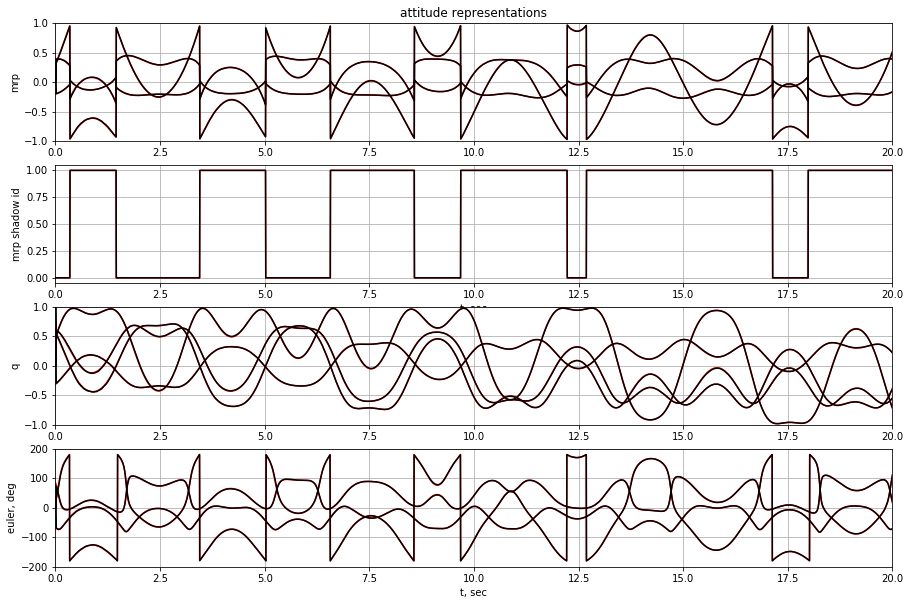

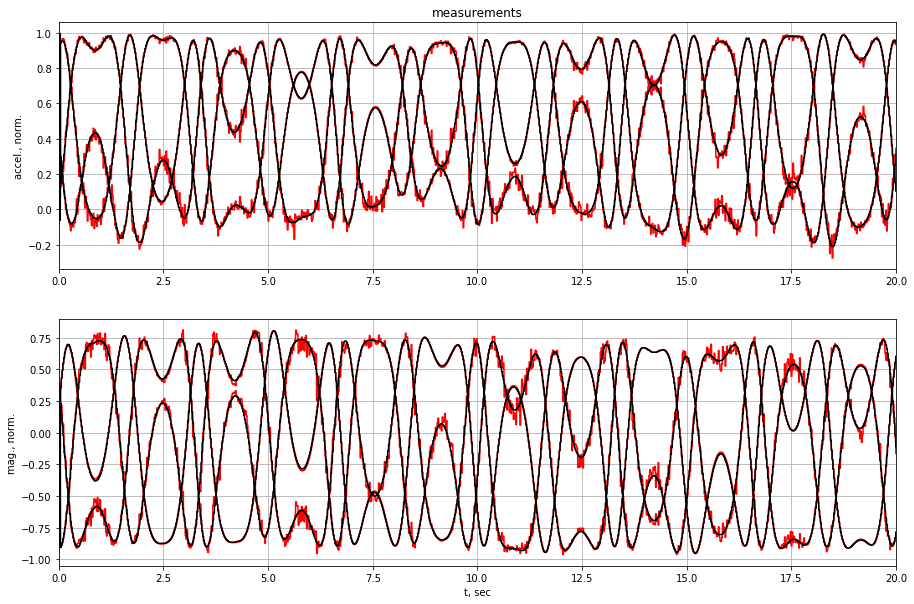

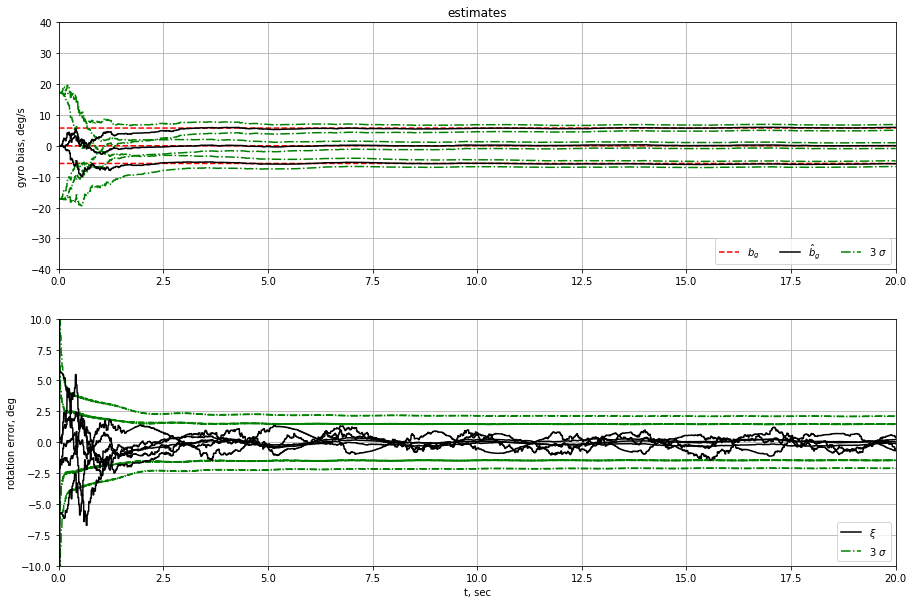

In [17]:
def f_omega(t):
    """angular velocity of vehicle as a function of time, in the body frame"""
    return 1*np.array([0.1, 0.2, 0.3]) + 3*np.cos(2*np.pi*0.3*t)

sim_params = {
    # sampling
    't': 0,
    'tf': 20,
    'dt': 0.005, # 200 Hz
    'mod_accel': 4, # 50 Hz
    'mod_mag': 4, # 50 Hz
    'mag_delay_periods': 0,  # simulates measurement lag
    'accel_delay_periods': 0,  # simulates measurement lag
    'max_delay_periods': 10,
    
    # measurement noise
    'accel_sqrt_N': 0.005,  # accel sqrt of noise power
    'mag_sqrt_N': 0.01, # mag sqrt of noise power

    # initial uncertainty
    'std0_att': 3.0,
    'std0_bias': 0.1,
    
    # process noise
    'std_w_att': 0.001, # main tuning parameter
    'std_w_bias': 0.0001,
    
    # angular velocity function
    'f_omega': f_omega,
    
    # initial conditions for simulated rigid body
    'x0': 1*np.array([0.4, -0.2, 0.3, 0.1, 0, -0.1]),
}


hist = sim(func, sim_params)
analyze_hist(hist)
plot_hist(hist)